# __Categorize a continuous variable__
> * Here is a quick and scalable way to categorize a continuous variable into different levels.  
> * We use a method called **continuous-mean** to find the cut points by input column. There's no need to use hardcode settings.
> * The process is data-driven and easy to apply. However, domain experts must still review and revise the naive results if necessary.

---

## Import sample data
Data source: Kaggle, https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business/data    
You can check *../data_preparation.ipynb* if you want to reproduce the source data.

In [81]:
import polars as pl
import seaborn as sb
import matplotlib.pyplot as plt

agg_uid = pl.read_csv("../data_source/kaggle_data/Sales_Transaction_v4a/agg_uid.csv", try_parse_dates = True)
agg_uid.select('cust_id', 'n_days').rename({"n_days": "number-of-active-days"})

cust_id,number-of-active-days
i64,i64
15421,3
12534,1
14739,8
12789,1
14215,6
…,…
12436,1
14877,1
16532,3


## Quick Check
We've aggregated the total number of active days by each member. The distribution is right-skew. Over **75%** of members' active days are under **4** days, and many members just purchase **1** to **2** times. This is a classic scenario when we analyze customer behavior data.

In [10]:
agg_uid.select('n_days').rename({"n_days": "number-of-active-days"}).describe()

statistic,number-of-active-days
str,f64
"""count""",4718.0
"""null_count""",0.0
"""mean""",3.826621
"""std""",5.752403
"""min""",1.0
"""25%""",1.0
"""50%""",2.0
"""75%""",4.0
"""max""",130.0


Text(0.5, 0, 'number-of-active-days')

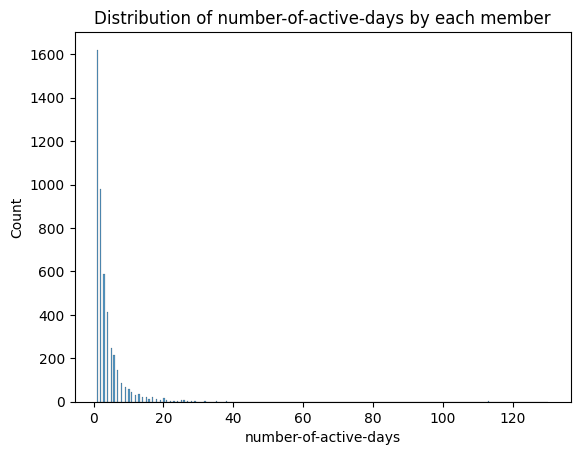

In [11]:
g = sb.histplot(data = agg_uid, x = "n_days")
g.set_title("Distribution of number-of-active-days by each member")
g.set_xlabel("number-of-active-days")

---

## Process of Continuous-Mean 

### Intuitive way

In [12]:
x = agg_uid.select('n_days').to_series()

m1 = x.mean()
m2 = x.filter(x > m1).mean()
m3 = x.filter(x > m2).mean()

y = (
    pl.Series(['L'] * len(x))
    .set(x > m1, 'M')
    .set(x > m2, 'H')
    .set(x > m3, 'T')
)

cate_enum = pl.Enum(['T', 'H', 'M', 'L'])
y = pl.Series(y, dtype = cate_enum)
y.value_counts().sort(by = "")

,count
enum,u32
"""T""",122
"""H""",296
"""M""",1109
"""L""",3191


### Create a general function
Users can set how many groups they want and the Enum list.

In [84]:
def continuous_mean_grouping(x: pl.Series, n_group: int, high_to_low_name: list[str] = None) -> pl.Series:
    
    if high_to_low_name is not None and len(high_to_low_name) != n_group:
        raise ValueError("The length of high_to_low_name must be equal to n_group!")
        
    N = n_group    
    m0 = x.min() - 1
    
    if high_to_low_name is None:
        names = [j+1 for j in range(N)]
        y = pl.Series([N] * len(x))
    elif high_to_low_name is not None: 
        names = high_to_low_name
        y = pl.Series([names[-1]] * len(x))
    
    for i in range(N-1):
        m1 = x.filter(x > m0).mean()
        y = y.set(x > m1, names[-i-2])
        m0 = m1

    if high_to_low_name is not None: 
        cate_enum = pl.Enum(names)
        return pl.Series(y, dtype = cate_enum)
    else:
        return y


agg_uid = (
    agg_uid
    .with_columns(
        thml_n_days = pl.col('n_days').map_batches(lambda x: continuous_mean_grouping(x, n_group = 4, high_to_low_name = ['T', 'H', 'M', 'L']))
    )
)

agg_uid.select('cust_id', 'n_days', 'thml_n_days').sample(n = 10)

cust_id,n_days,thml_n_days
i64,i64,enum
14051,22,"""T"""
13636,6,"""M"""
13746,2,"""L"""
13026,5,"""M"""
13138,6,"""M"""
16809,6,"""M"""
16274,1,"""L"""
13927,1,"""L"""
13666,3,"""L"""


---

## Application

### Check the grouping boundary and member count.
It can help us identify or highlight the heavy users.

In [14]:
(
    agg_uid
    .group_by('thml_n_days')
    .agg(
        min_v = pl.col('n_days').min(),
        max_v = pl.col('n_days').max(),
        mean_v = pl.col('n_days').mean().round(2),
        people = pl.len()
    )
    .sort(by = 'thml_n_days')
)

thml_n_days,min_v,max_v,mean_v,people
enum,i64,i64,f64,u32
"""T""",17,130,28.07,122
"""H""",9,16,11.41,296
"""M""",4,8,5.32,1109
"""L""",1,3,1.68,3191


### Cross other dimension
It can help us find more insights about the members.

In [73]:
main_data = pl.read_csv('../data_source/kaggle_data/Sales_Transaction_v4a/main.csv', try_parse_dates = True)

sub_rst = (
    main_data
    .join(
        agg_uid.select('cust_id', 'thml_n_days'),
        how = "left",
        on = "cust_id"
    )
    .group_by('thml_n_days', 'pname')
    .agg(
        sum_quantity = pl.col('quantity').sum()
    )
    .with_columns(
        prop = pl.col('sum_quantity')/pl.col('sum_quantity').sum().over('thml_n_days'),
        seq = pl.col('sum_quantity').rank(descending = True).over('thml_n_days')
    )
    .sort(by = ['thml_n_days', 'sum_quantity'], descending = [False, True])
    .filter(pl.col('seq') <= 10)
)

Text(0.5, 1.0, 'Quantity distribution of purchasing product (Top 10 by each group)')

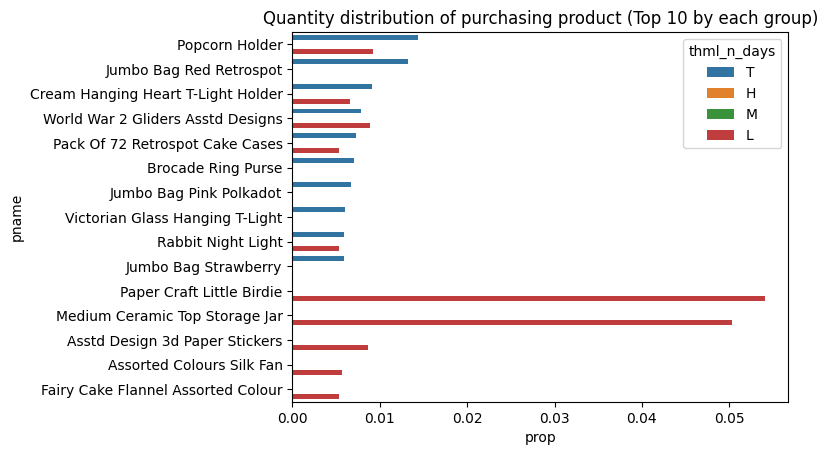

In [80]:
tmp_data = sub_rst.filter(pl.col('thml_n_days').is_in(['T','L']))
g = sb.barplot(data = tmp_data, x = "prop", y = "pname", hue = "thml_n_days")
g.set_title("Quantity distribution of purchasing product (Top 10 by each group)")